In [599]:
# alle overige kolommen met NAN waardes
#redwines[redwines.isnull().any(axis=1)].head(20)

In [600]:
# importeer nodige libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [601]:
# lees het bestand in
redwines = pd.read_csv("redwine.csv", delimiter=";", encoding='iso-8859-1')

In [602]:
# verwijder onnodige kolommen
redwines.drop(['country','variety'],axis=1, inplace=True)

In [603]:
# set column id als index
redwines.set_index('id', inplace=True)

In [604]:
# voeg jaartal toe als aparte kolom, en verwijder nan rijen voor jaren (2465 naar 2461)
redwines['year'] = redwines['title'].str.extract(r"([1][9][9]\d|[2][0][0,1,2]\d)")
redwines = redwines[redwines['year'].notnull()]

In [605]:
# drop rows with nan value in it
redwines.dropna(inplace=True)

In [606]:
# lees tabel statistieken uit
redwines.describe()

,points,price,fixed acidity,volatile acidity,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,pH,sulphates
count,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000
mean,88.860194,24.703398,8.349272,0.529723,2.574587,0.087831,16.008252,47.775243,3.310869,0.662427
std,2.947800,25.716501,1.742572,0.180143,1.419112,0.047329,10.423659,33.478012,0.155111,0.173984
min,81.000000,5.000000,4.600000,0.120000,0.900000,0.012000,1.000000,6.000000,2.740000,0.330000
25%,87.000000,12.000000,7.100000,0.400000,1.900000,0.070000,8.000000,23.000000,3.210000,0.550000
50%,88.000000,17.000000,7.900000,0.520000,2.200000,0.079000,14.000000,38.000000,3.305000,0.620000
75%,91.000000,28.000000,9.300000,0.635000,2.600000,0.090250,21.000000,65.000000,3.400000,0.730000
max,100.000000,450.000000,15.900000,1.580000,15.500000,0.610000,72.000000,289.000000,4.010000,2.000000


Het is belangrijk om inzicht te hebben in hoe de punten zijn verdeeld. Na een korte analyse kwamen we erachter dat alle punten zijn verdeeld tussen 80 en 100. Daarmee is een wijn van 80 punten opeens de slechtst beoordeelde wijn terwijl het lijkt alsof dit een redelijk hoge score is. In onderstaande bar plot is te zien hoe de punten zijn verdeeld 

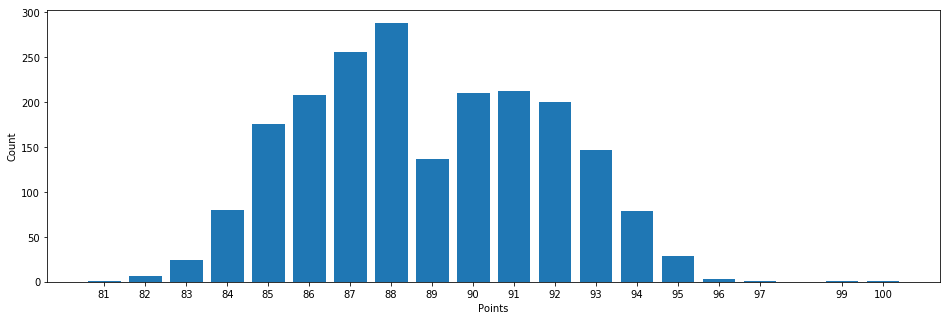

In [607]:
# punt verdeling
redwines['count'] = 1
points = redwines.groupby('points').sum()
plt.figure(figsize=(16,5))
plt.xticks(points.index)
plt.bar(points.index, points['count'])
plt.xlabel('Points')
plt.ylabel('Count')
plt.show()

We vroegen ons als groepje ook af wat de correlatie is tussen wijn prijs en gegeven punten. Je zou zeggen dat de duurdere wijnen ook beter beoordeeld moeten zijn. Het aantal punten zou dus moeten oplopen naarmate de prijs hoger wordt. Dit bleek ook enigzins het geval zoals in de onderstaande scatter plot te zien is. Al valt het nog iets mee, en daarnaast is het ook lastig te zeggen aangezien het onderlinge verschil tussen gegeven punten niet erg hoog is.

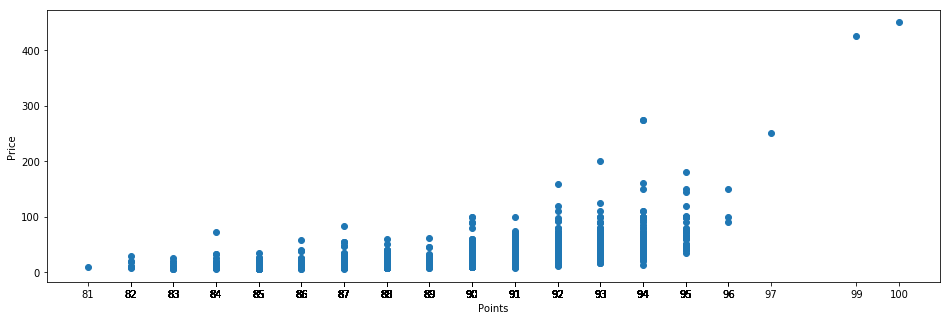

In [608]:
# Points comparison to price
plt.figure(figsize=(16,5))
plt.scatter(redwines['points'], redwines['price'])
plt.xticks(redwines['points'])
plt.xlabel('Points')
plt.ylabel('Price')
plt.show()

Ook dachten we dat er misschien een verband tussen goedkope wijn en veel suiker zou zijn, i.v.m. het feit dat suiker een goedkope grondstof is. Dit bleek echter minder uit te maken dan we eerst dachten. Er is geen overduidelijk verband te vinden tussen lagere wijnprijzen en hogere suikergehaltes zoals in de onderstaande scatter plot te zien is.

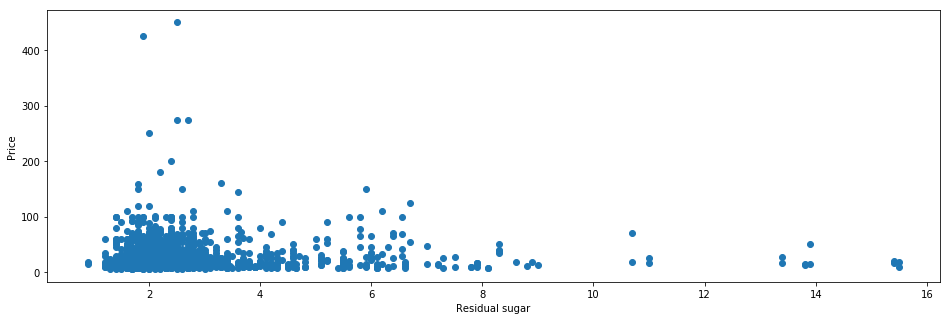

In [609]:
# Sugar comparison to price
plt.figure(figsize=(16,5))
plt.scatter(redwines['residual sugar'], redwines['price'])
plt.ylabel('Price')
plt.xlabel('Residual sugar')
plt.show()